In [45]:
import pandas as pd
pd.set_option('display.precision', 3)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

import os, sys
sys.path.append('./analysis/')

# import tqdm for notebooks
from tqdm.notebook import tqdm

# autoreload
%load_ext autoreload
%autoreload 2
import utils
from utils import SUBARXIV_NAMES_DICT, RECENT_DATE_THRESHOLD

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Look at papers written by new authors vs. experienced authors

Intuitively, we'd expect that people who have only recently started writing about LLMs are covering different topics than people who have been writing about LLMs prior to this year.

To perform this analysis, we'll split papers from 2023 into two buckets: one where the first author has co-authored an LLM paper before 2023, and another where the first author has not co-authored any other LLM papers. We will compare the topics of papers from these two buckets.

In [46]:
# lm_metadata = utils.load_annotated_lm_metadata()
lm_metadata = pd.read_json(os.path.join(utils.PROCESSED_DATA_DIR, 'lm_metadata_all_annotations.json'), 
                           orient='records', lines=True)
lm_metadata['v1_date'] = pd.to_datetime(lm_metadata['v1_date'], unit='ms')
print("N papers:", len(lm_metadata))
lm_metadata.sample(5)

N papers: 16979


,id,authors,title,categories,abstract,versions,first_category,v1_date,LM_related_terms,mentions_LM_keyword,cluster,domains,industry,academic,above_pred_female_threshold,inferred_female_frac_nqg_uncertainty_threshold_0.100,citationCount,percentile_rank_in_3_month_window,percentile_rank_in_12_month_window
6118,arXiv:2111.00396,"[Albert Gu, Karan Goel, Christopher Ré]",Efficiently Modeling Long Sequences with Struc...,[cs.LG],A central goal of sequence modeling is desig...,"[{'version': 'v1', 'created': 'Sun, 31 Oct 202...",cs.LG,2021-10-31 03:32:18,[language model],True,"Transformers, RNNs, Attention",[stanford.edu],False,True,0.0,0.0,196.0,0.977,0.976
10394,arXiv:2212.10071,"[Namgyu Ho, Laura Schmid, Se-Young Yun]",Large Language Models Are Reasoning Teachers,"[cs.CL, cs.AI, cs.LG]",Recent works have shown that chain-of-though...,"[{'version': 'v1', 'created': 'Tue, 20 Dec 202...",cs.CL,2022-12-20 08:24:45,"[language model, large language model, GPT-3]",True,"LLMs, Reasoning, Chain-of-Thought",[kaist.ac.kr],False,True,1.0,1.0,47.0,0.966,0.944
4925,arXiv:2106.11251,"[Xiao Wang, Craig Macdonald, Nicola Tonellotto...",Pseudo-Relevance Feedback for Multiple Represe...,[cs.IR],"Pseudo-relevance feedback mechanisms, from R...","[{'version': 'v1', 'created': 'Mon, 21 Jun 202...",cs.IR,2021-06-21 16:49:03,"[language model, BERT]",True,"Search, Ranking, Retrieval",[],False,False,0.0,0.0,42.0,0.855,0.874
478,arXiv:1904.06707,"[Timo Schick, Hinrich Schütze]",Rare Words: A Major Problem for Contextualized...,"[cs.CL, cs.LG]",Pretraining deep neural network architecture...,"[{'version': 'v1', 'created': 'Sun, 14 Apr 201...",cs.CL,2019-04-14 15:26:52,"[language model, BERT]",True,"Representations, Syntax, Semantics","[sulzer.de, lmu.de]",False,True,0.0,0.0,70.0,0.633,0.693
6490,arXiv:2112.08616,"[Daniel Spokoyny, Ivan Lee, Zhao Jin, Taylor B...",Masked Measurement Prediction: Learning to Joi...,"[cs.CL, cs.LG]",Physical measurements constitute a large por...,"[{'version': 'v1', 'created': 'Thu, 16 Dec 202...",cs.CL,2021-12-16 04:42:13,"[pretrained language model, language model, BERT]",True,"LLMs, Reasoning, Chain-of-Thought","[ucsd.edu, cmu.edu]",False,True,0.0,0.0,4.0,0.400,0.315


In [47]:
pre_2023_lm_authors = utils.get_experienced_llm_authors(lm_metadata)
lm_papers_2023 = lm_metadata[lm_metadata.v1_date >= RECENT_DATE_THRESHOLD].copy()
print("Number of LLM papers in 2023:", len(lm_papers_2023))

Number of total co-authors on LLM papers: 84270
Number of total co-authors on LLM papers before 2023-01-01: 24789
Number of LLM papers in 2023: 6427


In [49]:
'''
Split papers into two groups:
- Group 1 (experienced): papers first-authored by people who have co-authored an LLM paper before 2023
- Group 2 (new): papers first-authored by people who have not co-authored an LLM paper before 2023

This requires first getting a set of authors who have co-authored an LLM paper before 2023.
'''

# Add a column to lm_papers_2023 indicating whether the first author is experienced or new
lm_papers_2023['experienced_first_author'] = lm_papers_2023.apply(lambda paper: paper.authors[0] in pre_2023_lm_authors, axis=1)
lm_papers_2023['new_first_author'] = lm_papers_2023.apply(lambda paper: paper.authors[0] not in pre_2023_lm_authors, axis=1)

assert len(lm_papers_2023) == len(lm_papers_2023[lm_papers_2023.experienced_first_author]) + len(lm_papers_2023[lm_papers_2023.new_first_author])
print("Number of papers by experienced first authors:", len(lm_papers_2023[lm_papers_2023.experienced_first_author]))
print("Number of papers by new first authors:", len(lm_papers_2023[lm_papers_2023.new_first_author]))

# Analogous for last author
lm_papers_2023['experienced_last_author'] = lm_papers_2023.apply(lambda paper: paper.authors[-1] in pre_2023_lm_authors, axis=1)
lm_papers_2023['new_last_author'] = lm_papers_2023.apply(lambda paper: paper.authors[-1] not in pre_2023_lm_authors, axis=1)

assert len(lm_papers_2023) == len(lm_papers_2023[lm_papers_2023.experienced_last_author]) + len(lm_papers_2023[lm_papers_2023.new_last_author])
print("Number of papers by experienced last authors:", len(lm_papers_2023[lm_papers_2023.experienced_last_author]))
print("Number of papers by new last authors:", len(lm_papers_2023[lm_papers_2023.new_last_author]))

lm_papers_2023.sample(5, random_state=0)

# Also count the number of papers with ZERO experienced authors
lm_papers_2023['zero_experienced_authors'] = lm_papers_2023.apply(lambda paper: sum([author in pre_2023_lm_authors for author in paper.authors]) == 0, axis=1)
print("Number of papers with zero experienced authors:", len(lm_papers_2023[lm_papers_2023.zero_experienced_authors]))
print("Number of papers with at least one experienced author:", len(lm_papers_2023[~lm_papers_2023.zero_experienced_authors]))

Number of papers by experienced first authors: 2479
Number of papers by new first authors: 3948
Number of papers by experienced last authors: 3908
Number of papers by new last authors: 2519
Number of papers with zero experienced authors: 1490
Number of papers with at least one experienced author: 4937


Chi2 test for Search & Retrieval: p = 6.221e-05 (not multiple hypothesis corrected)
Chi2 test for Knowledge Graphs & Commonsense: p = 3.115e-05 (not multiple hypothesis corrected)
Chi2 test for Summarization & Evaluation: p = 5.298e-03 (not multiple hypothesis corrected)
Chi2 test for Prompts & In-Context Learning: p = 3.610e-04 (not multiple hypothesis corrected)
Chi2 test for Interpretability & Reasoning: p = 3.294e-03 (not multiple hypothesis corrected)
Chi2 test for Privacy & Adversarial Risks: p = 6.972e-04 (not multiple hypothesis corrected)
Chi2 test for Emotion & Sentiment Analysis: p = 3.725e-02 (not multiple hypothesis corrected)
Chi2 test for Social Media & Misinformation: p = 6.113e-03 (not multiple hypothesis corrected)
Chi2 test for Visual Foundation Models: p = 1.439e-05 (not multiple hypothesis corrected)
Chi2 test for Applications of LLMs/ChatGPT: p = 1.436e-17 (not multiple hypothesis corrected)


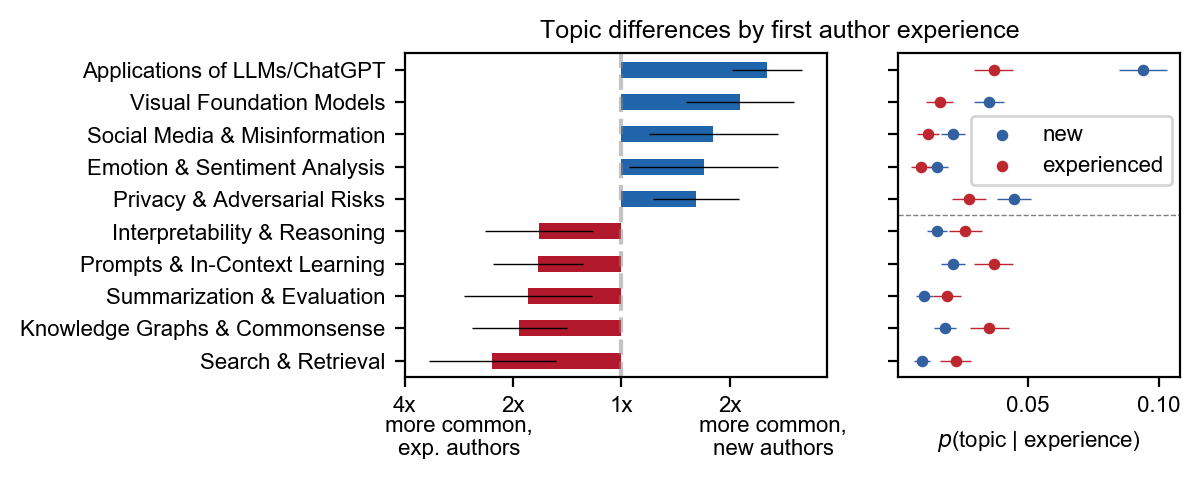

In [50]:
# Compute enriched topics for new authors

first_author_experience_topic_df = utils.get_topic_counts_by_binary_variable(lm_papers_2023, 'new_first_author', 'cluster')

f, (enrich_ax, dot_ax) = utils.enrichment_plot_and_dotplot(
    first_author_experience_topic_df,
    bar_names_col='topic',
    pos_label='more common,\nnew authors',
    neg_label='more common,\nexp. authors',
    true_label='new',
    false_label='experienced',
    legend_coords=(0.22, 0.84),
    width_ratios=(3, 2),
    dotplot_xlabel=r'$p$(topic | experience)',
    top_and_bottom_k=5,
    manual_enrichment_xlim=(2, 1.9),
    dpi=200,
)


f.suptitle("Topic differences by first author experience", y=0.96, fontsize=9)
# f.savefig('./analysis/figures/topic_barplot_first_author_experience.pdf', bbox_inches='tight', dpi=300)

plt.show()

Chi2 test for Interpretability & Reasoning: p = 7.238e-07 (not multiple hypothesis corrected)
Chi2 test for Search & Retrieval: p = 2.936e-05 (not multiple hypothesis corrected)
Chi2 test for Knowledge Distillation: p = 1.513e-02 (not multiple hypothesis corrected)
Chi2 test for Prompts & In-Context Learning: p = 1.126e-06 (not multiple hypothesis corrected)
Chi2 test for Summarization & Evaluation: p = 1.315e-03 (not multiple hypothesis corrected)
Chi2 test for Natural Sciences: p = 3.815e-03 (not multiple hypothesis corrected)
Chi2 test for Software, Planning, Robotics: p = 2.657e-07 (not multiple hypothesis corrected)
Chi2 test for Finance Applications: p = 3.623e-03 (not multiple hypothesis corrected)
Chi2 test for Societal Implications of LLMs: p = 5.149e-09 (not multiple hypothesis corrected)
Chi2 test for Applications of LLMs/ChatGPT: p = 2.313e-45 (not multiple hypothesis corrected)


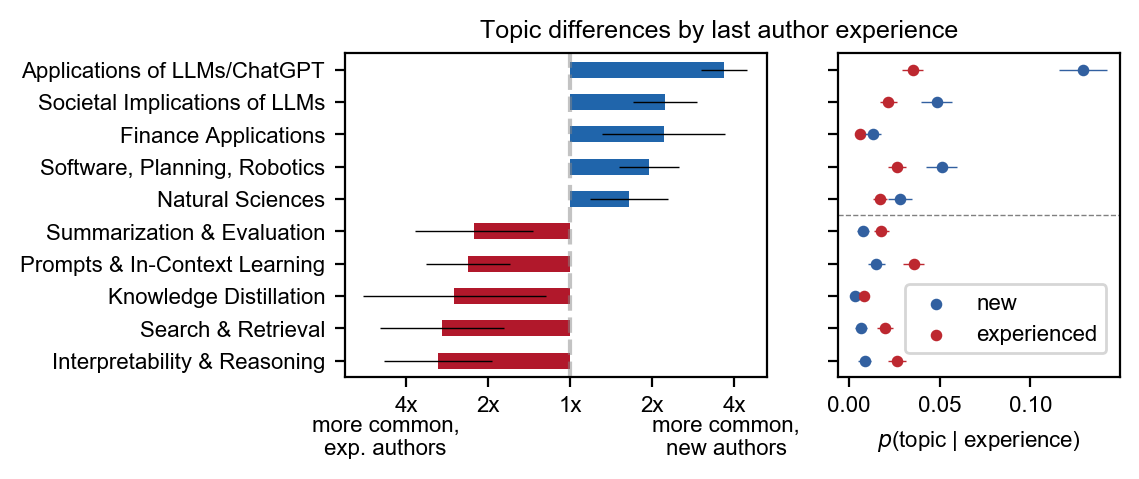

In [51]:
# Compute enriched topics for experienced authors

last_author_experience_topic_df = utils.get_topic_counts_by_binary_variable(lm_papers_2023, 'new_last_author', 'cluster')

f, (enrich_ax, dot_ax) = utils.enrichment_plot_and_dotplot(
    last_author_experience_topic_df,
    bar_names_col='topic',
    pos_label='more common,\nnew authors',
    neg_label='more common,\nexp. authors',
    true_label='new',
    false_label='experienced',
    legend_coords=(0.2, 0.32),
    width_ratios=(3, 2),
    dotplot_xlabel=r'$p$(topic | experience)',
    top_and_bottom_k=5,
    manual_enrichment_xlim=(2.75, 2.4),
    dpi=200,
)


f.suptitle("Topic differences by last author experience", y=0.96, fontsize=9)
# f.savefig('./analysis/figures/topic_barplot_last_author_experience.pdf', bbox_inches='tight', dpi=300)

plt.show()

Chi2 test for Search & Retrieval: p = 1.433e-04 (not multiple hypothesis corrected)
Chi2 test for Interpretability & Reasoning: p = 1.007e-05 (not multiple hypothesis corrected)
Chi2 test for Knowledge Graphs & Commonsense: p = 3.659e-05 (not multiple hypothesis corrected)
Chi2 test for Prompts & In-Context Learning: p = 8.830e-05 (not multiple hypothesis corrected)
Chi2 test for Fine-Tuning & Domain Adaptation: p = 1.258e-04 (not multiple hypothesis corrected)
Chi2 test for Social Media & Misinformation: p = 3.292e-02 (not multiple hypothesis corrected)
Chi2 test for Emotion & Sentiment Analysis: p = 2.288e-02 (not multiple hypothesis corrected)
Chi2 test for Societal Implications of LLMs: p = 3.255e-07 (not multiple hypothesis corrected)
Chi2 test for Finance Applications: p = 5.504e-04 (not multiple hypothesis corrected)
Chi2 test for Applications of LLMs/ChatGPT: p = 3.325e-60 (not multiple hypothesis corrected)


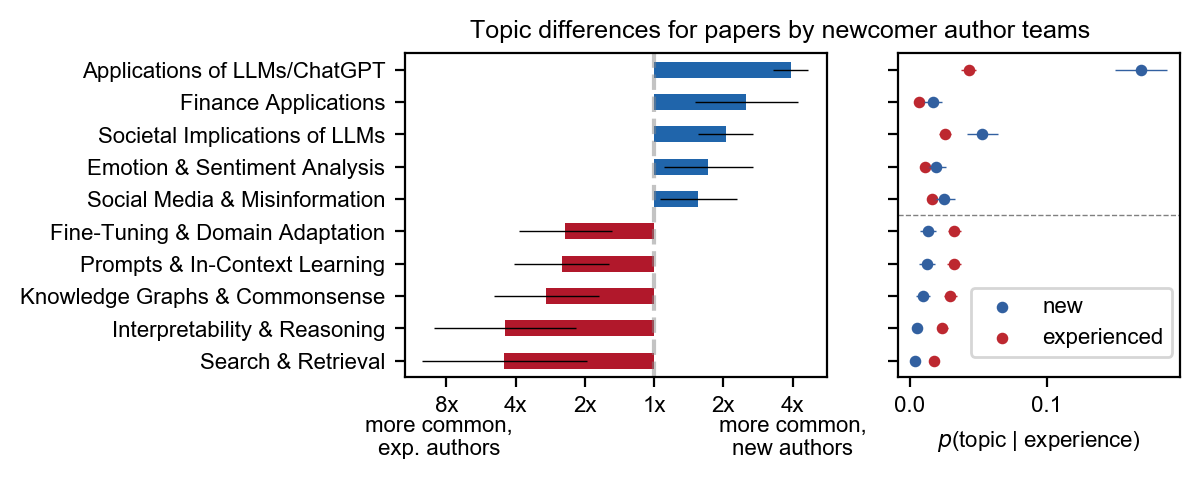

In [85]:
# Compute enriched topics for papers with zero experienced authors

zero_experienced_authors_topic_df = utils.get_topic_counts_by_binary_variable(lm_papers_2023, 'zero_experienced_authors', 'cluster')

f, (enrich_ax, dot_ax) = utils.enrichment_plot_and_dotplot(
    zero_experienced_authors_topic_df,
    bar_names_col='topic',
    pos_label='more common,\nnew authors',
    neg_label='more common,\nexp. authors',
    true_label='new',
    false_label='experienced',
    legend_coords=(0.22, 0.31),
    width_ratios=(3, 2),
    dotplot_xlabel=r'$p$(topic | experience)',
    top_and_bottom_k=5,
    manual_enrichment_xlim=(3.6, 2.5),
    dpi=200,
)


f.suptitle("Topic differences for papers by newcomer author teams", y=0.96, fontsize=9)
# f.savefig('./analysis/figures/topic_barplot_zero_experienced_authors.pdf', bbox_inches='tight', dpi=300)

plt.show()

In [78]:
display(zero_experienced_authors_topic_df.head())

Number of zero_experienced_authors papers that have first_category == 'cs.CY': 86


,topic,ratio,count_true,count_false,p_topic_if_true,p_topic_if_false,p_chi2
1,Applications of LLMs/ChatGPT,3.923,"(251, 1490)","(212, 4937)",0.168,0.043,3.325e-60
10,Finance Applications,2.510,"(25, 1490)","(33, 4937)",0.017,0.007,5.504e-04
28,Societal Implications of LLMs,2.045,"(79, 1490)","(128, 4937)",0.053,0.026,3.255e-07
8,Emotion/Sentiment Analysis,1.716,"(29, 1490)","(56, 4937)",0.019,0.011,2.288e-02
27,Social Media & Misinformation,1.552,"(37, 1490)","(79, 4937)",0.025,0.016,3.292e-02


In [84]:
# Count the % of zero_experienced_authors == True papers that include 'ChatGPT' the abstract, compared to the zero_experienced_authors == False papers
keyword = 'ChatGPT'
zero_exp_authors_keyword_count = len(lm_papers_2023[(lm_papers_2023.zero_experienced_authors) & (lm_papers_2023.abstract.str.contains(keyword))])
zero_exp_authors_keyword_count_pct = zero_exp_authors_keyword_count / len(lm_papers_2023[lm_papers_2023.zero_experienced_authors])
print(f"Fraction of papers with zero experienced authors that include '{keyword}' in the abstract: {zero_exp_authors_keyword_count_pct:.2f}")

non_zero_exp_authors_keyword_count = len(lm_papers_2023[(~lm_papers_2023.zero_experienced_authors) & (lm_papers_2023.abstract.str.contains(keyword))])
non_zero_exp_authors_keyword_count_pct = non_zero_exp_authors_keyword_count / len(lm_papers_2023[~lm_papers_2023.zero_experienced_authors])
print(f"Fraction of papers with at least one experienced author that include '{keyword}' in the abstract: {non_zero_exp_authors_keyword_count_pct:.2f}")

Fraction of papers with zero experienced authors that include 'ChatGPT' in the abstract: 0.25
Fraction of papers with at least one experienced author that include 'ChatGPT' in the abstract: 0.13


In [77]:
# Print some examples of papers written by first-time authors in various clusters

print("Applications of LLMs/ChatGPT")
display(lm_papers_2023[(lm_papers_2023.zero_experienced_authors) & (lm_papers_2023.cluster == 'Applications of LLMs/ChatGPT')].sort_values(by='citationCount', ascending=False).head(10))

print("Social Media & Misinformation")
display(lm_papers_2023[(lm_papers_2023.zero_experienced_authors) & (lm_papers_2023.cluster == 'Social Media & Misinformation')].sort_values(by='citationCount', ascending=False).head(10))

,id,authors,title,categories,abstract,versions,first_category,v1_date,LM_related_terms,mentions_LM_keyword,...,above_pred_female_threshold,inferred_female_frac_nqg_uncertainty_threshold_0.100,citationCount,percentile_rank_in_3_month_window,percentile_rank_in_12_month_window,experienced_first_author,new_first_author,experienced_last_author,new_last_author,zero_experienced_authors
12178,arXiv:2304.07759,"[Ciprian-Octavian Truică, Elena-Simona Apostol]",MisRoB{\AE}RTa: Transformers versus Misinforma...,"[cs.CL, cs.AI]",Misinformation is considered a threat to our...,"[{'version': 'v1', 'created': 'Sun, 16 Apr 202...",cs.CL,2023-04-16 12:14:38,[BERT],True,...,NaN,NaN,11.0,0.921,0.916,False,True,False,True,True
10782,arXiv:2301.11924,"[Giovanni Spitale, Nikola Biller-Andorno, Fede...",AI model GPT-3 (dis)informs us better than humans,"[cs.CY, cs.AI, cs.HC]",Artificial intelligence is changing the way ...,"[{'version': 'v1', 'created': 'Mon, 23 Jan 202...",cs.CY,2023-01-23 14:36:29,[GPT-3],True,...,0.0,0.0,11.0,0.808,0.916,False,True,False,True,True
11783,arXiv:2303.15727,[Bishal Lamichhane],Evaluation of ChatGPT for NLP-based Mental Hea...,"[cs.CL, cs.AI]",Large language models (LLM) have been succes...,"[{'version': 'v1', 'created': 'Tue, 28 Mar 202...",cs.CL,2023-03-28 04:47:43,"[language model, large language model, ChatGPT]",True,...,0.0,0.0,8.0,0.773,0.892,False,True,False,True,True
10777,arXiv:2301.11843,"[Mubashara Akhtar, Oana Cocarascu, Elena Simperl]",Reading and Reasoning over Chart Images for Ev...,"[cs.CL, cs.CV]",Evidence data for automated fact-checking (A...,"[{'version': 'v1', 'created': 'Fri, 27 Jan 202...",cs.CL,2023-01-27 16:47:45,[BERT],True,...,1.0,1.0,5.0,0.690,0.841,False,True,False,True,True
15825,arXiv:2307.16336,"[Kai-Cheng Yang, Filippo Menczer]",Anatomy of an AI-powered malicious social botnet,"[cs.CY, cs.AI, cs.SI]",Large language models (LLMs) exhibit impress...,"[{'version': 'v1', 'created': 'Sun, 30 Jul 202...",cs.CY,2023-07-30 23:06:06,"[language model, large language model, ChatGPT]",True,...,0.0,0.0,2.0,0.895,0.685,False,True,False,True,True
11079,arXiv:2302.07740,"[Wei-Wei Du, Hong-Wei Wu, Wei-Yao Wang, Wen-Ch...",Team Triple-Check at Factify 2: Parameter-Effi...,"[cs.CL, cs.AI, cs.CV, cs.LG]",Multi-modal fact verification has become an ...,"[{'version': 'v1', 'created': 'Sun, 12 Feb 202...",cs.CL,2023-02-12 18:08:54,[foundation model],True,...,0.0,0.0,2.0,0.480,0.685,False,True,False,True,True
15808,arXiv:2307.15810,"[Zilin Ma, Yiyang Mei, Zhaoyuan Su]",Understanding the Benefits and Challenges of U...,[cs.HC],Conversational agents powered by large langu...,"[{'version': 'v1', 'created': 'Fri, 28 Jul 202...",cs.HC,2023-07-28 21:01:26,"[language model, large language model]",True,...,0.0,0.0,2.0,0.895,0.685,False,True,False,True,True
12515,arXiv:2304.14931,"[Abdurahman Maarouf, Dominik Bär, Dominique Ge...",HQP: A Human-Annotated Dataset for Detecting O...,[cs.CL],Online propaganda poses a severe threat to t...,"[{'version': 'v1', 'created': 'Fri, 28 Apr 202...",cs.CL,2023-04-28 15:42:55,[language model],True,...,0.0,0.0,2.0,0.652,0.685,False,True,False,True,True
12378,arXiv:2304.11924,"[Timo Hromadka, Timotej Smolen, Tomas Remis, B...",KInITVeraAI at SemEval-2023 Task 3: Simple yet...,"[cs.CL, cs.LG]",This paper presents the best-performing solu...,"[{'version': 'v1', 'created': 'Mon, 24 Apr 202...",cs.CL,2023-04-24 09:06:43,"[language model, BERT]",True,...,0.0,0.0,2.0,0.652,0.685,False,True,False,True,True
15672,arXiv:2307.12155,"[Christos Christodoulou, Nikos Salamanos, Pant...",Identifying Misinformation on YouTube through ...,[cs.CL],Misinformation on YouTube is a significant c...,"[{'version': 'v1', 'created': 'Sat, 22 Jul 202...",cs.CL,2023-07-22 19:59:16,[BERT],True,...,0.0,0.2,1.0,0.787,0.547,False,True,False,True,True


## Descriptive stats of new authors in 2023

Note that these results are not included in the paper.

### Academic vs. industry affiliation of papers written by new vs. experienced first authors

Note that these stats aren't really good comparisons, because it's possible that papers by new first authors just have fewer authors overall, which makes them less likely to have any type of affiliation. Because we don't know affiliation at an individual author-level, it's hard to interpret these results

In [44]:
papers_w_domain_2023 = lm_papers_2023[(lm_papers_2023.domains.apply(lambda x: len(x) > 0))] 
# papers_w_domain_2023 = lm_papers_2023[(lm_papers_2023.academic) | (lm_papers_2023.industry)].copy() # Restrict to papers with a tracked affiliation, not just a domain
n_new_first_auth_with_domain = papers_w_domain_2023['new_first_author'].sum()
n_exp_first_auth_with_domain = papers_w_domain_2023['experienced_first_author'].sum()

# New authors
n_academic_new = ((papers_w_domain_2023['new_first_author']) & (papers_w_domain_2023['academic'])).sum()
print(f'(N new authors in 2023 with academic affil) / (N new authors in 2023): {n_academic_new} out of {n_new_first_auth_with_domain} ({100*n_academic_new/n_new_first_auth_with_domain :.1f}%)')
n_industry_new = ((papers_w_domain_2023['new_first_author']) & (papers_w_domain_2023['industry'])).sum()
print(f'(N new authors in 2023 with industry affil) / (N new authors in 2023): {n_industry_new} out of {n_new_first_auth_with_domain} ({100*n_industry_new/n_new_first_auth_with_domain :.1f}%)')

# Experienced authors
n_academic_exp = ((papers_w_domain_2023['experienced_first_author']) & (papers_w_domain_2023['academic'])).sum()
print(f'(N experienced authors in 2023 with academic affil) / (N experienced authors in 2023): {n_academic_exp} out of {n_exp_first_auth_with_domain} ({100*n_academic_exp/n_exp_first_auth_with_domain :.1f}%)')
n_industry_exp = ((papers_w_domain_2023['experienced_first_author']) & (papers_w_domain_2023['industry'])).sum()
print(f'(N experienced authors in 2023 with industry affil) / (N experienced authors in 2023): {n_industry_exp} out of {n_exp_first_auth_with_domain} ({100*n_industry_exp/n_exp_first_auth_with_domain :.1f}%)')

(N new authors in 2023 with academic affil) / (N new authors in 2023): 2184 out of 3135 (69.7%)
(N new authors in 2023 with industry affil) / (N new authors in 2023): 544 out of 3135 (17.4%)
(N experienced authors in 2023 with academic affil) / (N experienced authors in 2023): 1600 out of 2056 (77.8%)
(N experienced authors in 2023 with industry affil) / (N experienced authors in 2023): 588 out of 2056 (28.6%)


In [41]:
# Now, replicate the above analysis but match on the number of authors per paper.
# Count the number of papers with 1, 2, 3, 4, 5, 6, 7, 8, 9, and 10+ authors in the experienced group, and then sample papers with the same author count distributions from the new group.
# Restrict to papers with >=1 domain: papers_w_domain_2023

# papers_w_domain_2023 = lm_papers_2023[(lm_papers_2023.domains.apply(lambda x: len(x) > 0))].copy()
papers_w_domain_2023 = lm_papers_2023[(lm_papers_2023.academic) | (lm_papers_2023.industry)].copy() # Restrict to papers with a tracked affiliation, not just a domain
papers_w_domain_2023['n_authors'] = papers_w_domain_2023.authors.apply(lambda x: len(x))

# Get the number of papers with 1, 2, 3, 4, 5, 6, 7, 8, 9, and 10+ authors in the experienced group
n_authors_counts_exp = papers_w_domain_2023[papers_w_domain_2023.experienced_first_author].n_authors.value_counts()

new_author_paper_subset = pd.DataFrame()
for n_authors, n_papers in n_authors_counts_exp.items():
    if n_authors >= 20:
        new_author_paper_subset = pd.concat([new_author_paper_subset, papers_w_domain_2023[papers_w_domain_2023.new_first_author & (papers_w_domain_2023.n_authors >= 10)].sample(n_papers, random_state=0)])
    else:
        new_author_paper_subset = pd.concat([new_author_paper_subset, papers_w_domain_2023[papers_w_domain_2023.new_first_author & (papers_w_domain_2023.n_authors == n_authors)].sample(n_papers, random_state=0, replace=True)])

# Compare industry/academic fraction for new vs. experienced authors

n_new_first_auth_with_domain = new_author_paper_subset['new_first_author'].sum()
n_exp_first_auth_with_domain = papers_w_domain_2023['experienced_first_author'].sum()

n_academic_new = ((new_author_paper_subset['new_first_author']) & (new_author_paper_subset['academic'])).sum()
n_industry_new = ((new_author_paper_subset['new_first_author']) & (new_author_paper_subset['industry'])).sum()
print(f'(N new authors in 2023 with academic affil) / (N new authors in 2023): {n_academic_new} out of {n_new_first_auth_with_domain} ({100*n_academic_new/n_new_first_auth_with_domain :.1f}%)')
print(f'(N new authors in 2023 with industry affil) / (N new authors in 2023): {n_industry_new} out of {n_new_first_auth_with_domain} ({100*n_industry_new/n_new_first_auth_with_domain :.1f}%)')

n_academic_exp = ((papers_w_domain_2023['experienced_first_author']) & (papers_w_domain_2023['academic'])).sum()
n_industry_exp = ((papers_w_domain_2023['experienced_first_author']) & (papers_w_domain_2023['industry'])).sum()
print(f'(N experienced authors in 2023 with academic affil) / (N experienced authors in 2023): {n_academic_exp} out of {n_exp_first_auth_with_domain} ({100*n_academic_exp/n_exp_first_auth_with_domain :.1f}%)')
print(f'(N experienced authors in 2023 with industry affil) / (N experienced authors in 2023): {n_industry_exp} out of {n_exp_first_auth_with_domain} ({100*n_industry_exp/n_exp_first_auth_with_domain :.1f}%)')

(N new authors in 2023 with academic affil) / (N new authors in 2023): 1705 out of 1856 (91.9%)
(N new authors in 2023 with industry affil) / (N new authors in 2023): 417 out of 1856 (22.5%)
(N experienced authors in 2023 with academic affil) / (N experienced authors in 2023): 1600 out of 1856 (86.2%)
(N experienced authors in 2023 with industry affil) / (N experienced authors in 2023): 588 out of 1856 (31.7%)


### Author count of papers written by new vs. experienced first authors

In [27]:
# Print value counts of the number of authors for papers with new vs. experienced first authors
# For example, it'd be interesting if many of the new authors are solo authors

print("Number of authors for papers with new first authors:")
print("Mean team size", round(lm_papers_2023[lm_papers_2023.new_first_author].authors.apply(len).mean(), 2))
print(lm_papers_2023[lm_papers_2023.new_first_author].authors.apply(len).value_counts()[:10] / len(lm_papers_2023[lm_papers_2023.new_first_author]))

print("Number of authors for papers with experienced first authors:")
print("Mean team size", round(lm_papers_2023[lm_papers_2023.experienced_first_author].authors.apply(len).mean(), 2))
print(lm_papers_2023[lm_papers_2023.experienced_first_author].authors.apply(len).value_counts()[:10] / len(lm_papers_2023[lm_papers_2023.experienced_first_author]))

Number of authors for papers with new first authors:
Mean team size 5.0
4     0.174
3     0.173
5     0.160
2     0.118
6     0.116
7     0.069
1     0.060
8     0.036
9     0.025
10    0.018
Name: authors, dtype: float64
Number of authors for papers with experienced first authors:
Mean team size 5.86
4     0.159
5     0.145
3     0.139
6     0.134
7     0.092
2     0.091
8     0.069
9     0.038
1     0.035
10    0.022
Name: authors, dtype: float64


### How many of the 2022 authors were new?

How surprising is it that >60% of the LLM first authors in 2023 are new? What was the stat in 2022 (we'd expect more of them to actually be new, since 2018-2021 didn't have many LLM papers).

In [73]:
from datetime import datetime

datetime_2022 = datetime(2022, 1, 1)
lm_metadata_authors = lm_metadata.explode('authors').rename(columns={'authors': 'author'})
non_2022_llm_authors = set(lm_metadata_authors[(lm_metadata_authors.v1_date < datetime_2022) | (lm_metadata_authors.v1_date >= RECENT_DATE_THRESHOLD)].author.unique())
print("Number of unique authors outside of 2022:", len(non_2022_llm_authors))
lm_papers_2022 = lm_metadata[(lm_metadata.v1_date >= datetime_2022) & (lm_metadata.v1_date < RECENT_DATE_THRESHOLD)].copy()
print("Number of LLM papers in 2022:", len(lm_papers_2022))

# Count the number of 2022 papers which were first-authored by new authors
lm_papers_2022['new_first_author'] = lm_papers_2022.apply(lambda paper: paper.authors[0] not in non_2022_llm_authors, axis=1)

print("Number of 2022 papers by new first authors:", len(lm_papers_2022[lm_papers_2022.new_first_author]))

Number of unique authors outside of 2022: 33126
Number of LLM papers in 2022: 3972
Number of 2022 papers by new first authors: 1500
